In [1]:
import os
import json
import pandas as pd
import numpy as np
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir(os.path.dirname(os.getcwd()))

import debias_vsi_clean as dv

In [2]:
df = dv.get_vsi_with_scores()
df

Evaluating /opt/hpcaas/.mounts/fs-072917c00f01ae1ba/home/ellisbrown/workspace/test-set-training/data/ref_evals/bld_sims_3q_10k_blind.jsonl: 100%|██████████| 5130/5130 [00:00<00:00, 8269.94it/s]
Evaluating /opt/hpcaas/.mounts/fs-072917c00f01ae1ba/home/ellisbrown/workspace/test-set-training/data/ref_evals/blk_sims_3q_10k_blind.jsonl: 100%|██████████| 5130/5130 [00:00<00:00, 10245.07it/s]
Evaluating /opt/hpcaas/.mounts/fs-072917c00f01ae1ba/home/ellisbrown/workspace/test-set-training/data/ref_evals/cambrian-s.jsonl: 100%|██████████| 5130/5130 [00:00<00:00, 9200.09it/s]
Evaluating /opt/hpcaas/.mounts/fs-072917c00f01ae1ba/home/ellisbrown/workspace/test-set-training/data/ref_evals/cambrian-s_blind.jsonl: 100%|██████████| 5130/5130 [00:00<00:00, 10064.34it/s]
Evaluating /opt/hpcaas/.mounts/fs-072917c00f01ae1ba/home/ellisbrown/workspace/test-set-training/data/ref_evals/gemini-1.5_pro.jsonl: 100%|██████████| 5156/5156 [00:00<00:00, 9004.49it/s]
Evaluating /opt/hpcaas/.mounts/fs-072917c00f01ae1ba

Loaded 5130 files. Loading VSI-Bench...


,id,dataset,scene_name,question_type,question,ground_truth,options,bld_sims_3q_10k_blind,blk_sims_3q_10k_blind,cambrian-s,...,rgb_sims_3q_25k,rgb_sims_3q_25k_blind,rgb_sims_manV2_5k,rgb_sims_manV2_5k_blind,vsi_train_10k,vsi_train_10k_blind,vsi_train_50k,vsi_train_50k_blind,vsi_train_5k,vsi_train_5k_blind
0,0,arkitscenes,41069025,object_counting,How many table(s) are in this room?,4,None,0.0,0.0,0.1,...,0.1,0.0,0.1,0.0,0.1,0.1,0.1,0.1,0.1,0.1
1,1,arkitscenes,41069025,object_counting,How many chair(s) are in this room?,2,None,0.1,0.1,1.0,...,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,1.0,1.0
2,2,arkitscenes,41069043,object_counting,How many table(s) are in this room?,2,None,0.1,0.1,1.0,...,1.0,0.1,1.0,0.1,1.0,1.0,1.0,1.0,1.0,1.0
3,3,arkitscenes,41125700,object_counting,How many sofa(s) are in this room?,2,None,0.1,0.1,1.0,...,0.1,0.1,0.1,0.1,1.0,1.0,1.0,1.0,1.0,1.0
4,4,arkitscenes,41125700,object_counting,How many table(s) are in this room?,3,None,0.0,0.0,0.4,...,0.4,0.0,0.4,0.0,0.4,0.4,0.4,0.4,0.4,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5125,5151,scannet,scene0196_00,route_planning,You are a robot beginning at the trash bin nea...,C,"[A. Turn Right, Turn Left, B. Turn Right, Turn...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5126,5152,scannet,scene0378_01,route_planning,You are a robot beginning at the door and faci...,A,"[A. Turn Left, Turn Left, Turn Left, B. Turn L...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5127,5153,arkitscenes,47331654,route_planning,You are a robot beginning at the heater and fa...,D,"[A. Turn Left, Turn Right, B. Turn Back, Turn ...",0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5128,5154,arkitscenes,42445026,route_planning,You are a robot beginning at the doorframe and...,C,"[A. Turn Left, B. Turn Back, C. Turn Right]",1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [4]:
import re

# question format: "What is the length of the longest dimension (length, width, or height) of the OBJECT, measured in centimeters?'"

qdf = df[df["question_type"] == "object_size_estimation"].copy()
qdf["object"] = qdf["question"].str.extract(r'height\) of the (.*), measured')[0]

qdf["object"].value_counts()

object
table              81
tv                 78
door               76
bed                62
chair              41
                   ..
washing machine     1
oven                1
mattress            1
guitar              1
piano               1
Name: count, Length: 64, dtype: int64

In [6]:
import re

# question format: "What is the length of the longest dimension (length, width, or height) of the OBJECT, measured in centimeters?'"

qdf = df[df["question_type"] == "object_size_estimation"].copy()
qdf["object"] = qdf["question"].str.extract(r'height\) of the (.*), measured')[0]

# Convert ground_truth to numeric, coercing errors to NaN
qdf["ground_truth"] = pd.to_numeric(qdf["ground_truth"], errors="coerce")

# Get mean and std of each object gt
def get_obj_stats(df):
    df = df.copy()
    df["ground_truth"] = pd.to_numeric(df["ground_truth"], errors="coerce")
    agg_df = df.groupby("object")["ground_truth"].agg(["count", "mean", "std"]).reset_index().sort_values("mean").fillna(0)
    agg_df["ratio"] = agg_df["std"] / agg_df["mean"]
    return agg_df.sort_values("ratio", ascending=False)

obj_agg_df = get_obj_stats(qdf)
obj_agg_df

,object,count,mean,std,ratio
12,coat rack,2,107.000000,107.480231,1.004488
8,ceiling light,12,71.750000,55.839258,0.778247
44,radiator,12,146.333333,110.417664,0.754563
21,exhaust fan,3,37.333333,27.153882,0.727336
29,lamp,13,73.153846,45.703476,0.624758
...,...,...,...,...,...
61,washing machine,1,86.000000,0.000000,0.000000
36,oven,1,113.000000,0.000000,0.000000
24,guitar,1,105.000000,0.000000,0.000000
39,piano,1,145.000000,0.000000,0.000000


In [13]:
print(obj_agg_df[obj_agg_df["count"] > 2][:5].head())

           object  count        mean         std     ratio
8   ceiling light     12   71.750000   55.839258  0.778247
44       radiator     12  146.333333  110.417664  0.754563
21    exhaust fan      3   37.333333   27.153882  0.727336
29           lamp     13   73.153846   45.703476  0.624758
11         closet      4  161.750000   91.255593  0.564177


In [ ]:
print(obj_agg_df[obj_agg_df["count"] > 2][-5:].head())

            object  count        mean        std     ratio
13  computer mouse      8   11.625000   1.060660  0.091240
3              bed     62  216.064516  17.201669  0.079614
27          kettle      5   23.800000   1.483240  0.062321
60          washer     21   87.095238   5.038896  0.057855
19      dishwasher      7   90.428571   3.359422  0.037150


In [15]:
obj_agg_df

,object,count,mean,std,ratio
12,coat rack,2,107.000000,107.480231,1.004488
8,ceiling light,12,71.750000,55.839258,0.778247
44,radiator,12,146.333333,110.417664,0.754563
21,exhaust fan,3,37.333333,27.153882,0.727336
29,lamp,13,73.153846,45.703476,0.624758
...,...,...,...,...,...
61,washing machine,1,86.000000,0.000000,0.000000
36,oven,1,113.000000,0.000000,0.000000
24,guitar,1,105.000000,0.000000,0.000000
39,piano,1,145.000000,0.000000,0.000000


In [19]:
obj_agg_df[obj_agg_df["count"] > 2]["ratio"].describe()

count    48.000000
mean      0.302890
std       0.185804
min       0.037150
25%       0.179176
50%       0.257227
75%       0.440991
max       0.778247
Name: ratio, dtype: float64

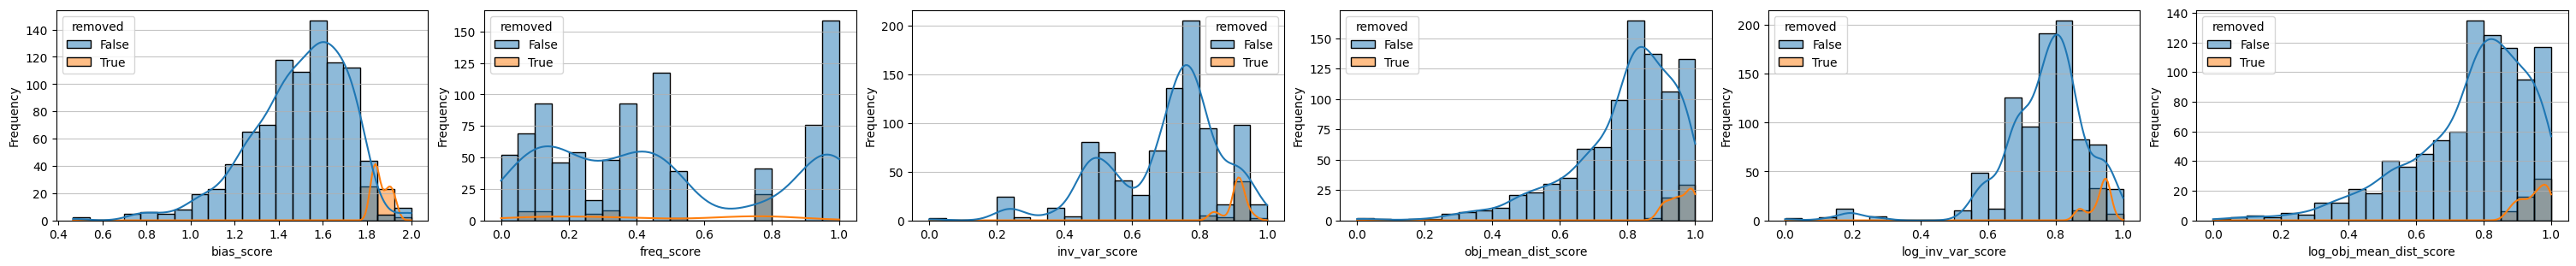

In [33]:
# budget = 500
budget = 50

w_freq = 0
w_ratio = 1
w_dist = 1
# logscale = True
logscale = False

remove_ids = dv.filter_object_size_estimation_scored_v2(qdf, budget, w_freq=w_freq, w_ratio=w_ratio, w_dist=w_dist, logscale=logscale)
df_filtered = dv.get_object_size_estimation_scores_v2(qdf, w_freq=w_freq, w_ratio=w_ratio, w_dist=w_dist, logscale=logscale)
df_sorted = df_filtered.sort_values("bias_score", ascending=False)
df_sorted["removed"] = df_sorted["id"].isin(remove_ids)


# scores = ["obj_freq_score", "val_freq_score", "combo_freq_score", "bias_score"]
# scores = ["pair_freq_score", "inv_var_score", "close_score", "bias_score"]
scores = [
    "bias_score",
    "freq_score",
    "inv_var_score",
    "obj_mean_dist_score",
    "log_inv_var_score",
    "log_obj_mean_dist_score",
]

# Visualize the distribution of scores in subplots
fig, axes = plt.subplots(1, len(scores), figsize=(5*len(scores), 3), constrained_layout=True)
if len(scores) == 1:
    axes = [axes]  # Ensure axes is iterable even if there's only one score

for i, score in enumerate(scores):
    sns.histplot(data=df_sorted, x=score, bins=20, kde=True, hue="removed", ax=axes[i])
    axes[i].set_ylabel("Frequency")
    axes[i].grid(axis='y', alpha=0.75)
plt.show()

In [34]:
remove_ids

[439,
 446,
 481,
 238,
 2322,
 345,
 206,
 321,
 393,
 267,
 226,
 293,
 478,
 254,
 2222,
 2312,
 2399,
 410,
 172,
 426,
 170,
 2378,
 475,
 2343,
 2230,
 203,
 508,
 3206,
 485,
 176,
 179,
 232,
 529,
 207,
 2391,
 3288,
 3429,
 3357,
 462,
 324,
 312,
 188,
 191,
 3215,
 2305,
 2364,
 2354,
 2348,
 3563,
 2353]

In [38]:
# remove column limit
pd.set_option('display.max_columns', None)
# df_sorted.head()
df_sorted[df_sorted["id"].isin(remove_ids)].head(10)

,id,dataset,scene_name,question_type,question,ground_truth,options,bld_sims_3q_10k_blind,blk_sims_3q_10k_blind,cambrian-s,cambrian-s_blind,gemini-1.5_pro,llava_vid_7b,llava_vid_7b_blind,qwen2.5_7b_blind,qwen2_7b_blind,rgb_sims_3q_10k_blind,rgb_sims_3q_25k,rgb_sims_3q_25k_blind,rgb_sims_manV2_5k,rgb_sims_manV2_5k_blind,vsi_train_10k,vsi_train_10k_blind,vsi_train_50k,vsi_train_50k_blind,vsi_train_5k,vsi_train_5k_blind,object,ground_truth_num,log_ground_truth,count,mean,std,log_mean,log_std,ratio,log_ratio,freq_score,inv_var_score,log_inv_var_score,norm_dist_from_mean,log_norm_dist_from_mean,obj_mean_dist_score,log_obj_mean_dist_score,global_mean_dist,log_global_mean_dist,bias_score,removed
272,439,arkitscenes,47332908,object_size_estimation,What is the length of the longest dimension (l...,87,None,0.0,0.0,1.0,1.0,0.4,0.2,0.0,0.0,0.0,0.0,0.4,0.0,0.6,0.0,1.0,0.0,1.0,1.0,1.0,1.0,washer,87,4.465908,21,87.095238,5.038896,4.465425,0.057406,0.057855,0.012856,0.2500,0.942403,0.955746,0.018901,0.008410,0.995019,0.997496,29.988458,0.084421,1.937423,True
279,446,arkitscenes,47333441,object_size_estimation,What is the length of the longest dimension (l...,87,None,0.0,0.0,1.0,1.0,0.4,0.2,0.0,0.0,0.0,0.0,0.1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,washer,87,4.465908,21,87.095238,5.038896,4.465425,0.057406,0.057855,0.012856,0.2500,0.942403,0.955746,0.018901,0.008410,0.995019,0.997496,29.988458,0.084421,1.937423,True
314,481,arkitscenes,47334117,object_size_estimation,What is the length of the longest dimension (l...,216,None,0.5,0.5,1.0,1.0,0.9,0.9,0.5,0.7,0.0,0.5,0.7,0.5,0.9,0.9,0.9,0.9,1.0,1.0,1.0,1.0,bed,216,5.375278,62,216.064516,17.201669,5.372490,0.079166,0.079614,0.014735,0.7625,0.920742,0.949276,0.003751,0.035227,0.999012,0.989510,99.011542,0.824949,1.919754,True
71,238,arkitscenes,42446529,object_size_estimation,What is the length of the longest dimension (l...,216,None,0.5,0.5,1.0,1.0,0.9,0.9,0.5,0.7,0.0,0.5,0.7,0.5,0.9,0.9,0.9,0.9,1.0,1.0,1.0,1.0,bed,216,5.375278,62,216.064516,17.201669,5.372490,0.079166,0.079614,0.014735,0.7625,0.920742,0.949276,0.003751,0.035227,0.999012,0.989510,99.011542,0.824949,1.919754,True
493,2322,scannetpp,25f3b7a318,object_size_estimation,What is the length of the longest dimension (l...,216,None,0.5,0.5,1.0,1.0,0.9,0.7,0.5,0.7,0.0,0.5,0.5,0.5,0.9,0.9,0.9,0.9,1.0,1.0,1.0,1.0,bed,216,5.375278,62,216.064516,17.201669,5.372490,0.079166,0.079614,0.014735,0.7625,0.920742,0.949276,0.003751,0.035227,0.999012,0.989510,99.011542,0.824949,1.919754,True
178,345,arkitscenes,45261182,object_size_estimation,What is the length of the longest dimension (l...,216,None,0.5,0.5,0.9,1.0,0.9,0.9,0.5,0.7,0.0,0.5,0.5,0.5,0.9,0.9,0.9,0.9,1.0,1.0,1.0,1.0,bed,216,5.375278,62,216.064516,17.201669,5.372490,0.079166,0.079614,0.014735,0.7625,0.920742,0.949276,0.003751,0.035227,0.999012,0.989510,99.011542,0.824949,1.919754,True
39,206,arkitscenes,42444976,object_size_estimation,What is the length of the longest dimension (l...,91,None,0.4,0.4,1.0,0.9,0.4,0.8,0.4,0.4,0.0,0.4,0.3,0.8,0.9,0.9,1.0,1.0,1.0,1.0,0.9,0.9,dishwasher,91,4.510860,7,90.428571,3.359422,4.503957,0.037721,0.037150,0.008375,0.0750,0.963016,0.971170,0.170097,0.182992,0.955175,0.945511,25.988458,0.039470,1.918191,True
154,321,arkitscenes,44358499,object_size_estimation,What is the length of the longest dimension (l...,91,None,0.4,0.4,1.0,0.9,0.4,0.0,0.4,0.4,0.0,0.4,0.4,0.8,0.0,0.9,1.0,1.0,1.0,1.0,0.9,0.9,dishwasher,91,4.510860,7,90.428571,3.359422,4.503957,0.037721,0.037150,0.008375,0.0750,0.963016,0.971170,0.170097,0.182992,0.955175,0.945511,25.988458,0.039470,1.918191,True
226,393,arkitscenes,47331063,object_size_estimation,What is the length of the longest dimension (l...,217,None,0.5,0.5,1.0,1.0,0.9,0.5,0.5,0.7,0.0,0.5,0.5,0.5,0.9,0.9,0.9,0.9,1.0,1.0,1.0,1.0,bed,217,5.379897,62,216.064516,17.201669,5.372490,0.079166,0.079614,0.014735,0.7625,0.920742,0.949276,0.054383,0.093572,0.985669,0.972137,100.011542,0.829568,1.906411,True
100,267,arkitscenes,42897692,object_size_es

In [37]:
df_sorted[df_sorted["id"].isin(remove_ids)]["object"].value_counts()

object
bed               21
bathtub            8
washer             5
keyboard           4
nightstand         3
dishwasher         2
chair              2
whiteboard         2
computer mouse     2
laptop             1
Name: count, dtype: int64

In [27]:
df_sorted[df_sorted["id"].isin([439, 481])]

,id,dataset,scene_name,question_type,question,ground_truth,options,bld_sims_3q_10k_blind,blk_sims_3q_10k_blind,cambrian-s,cambrian-s_blind,gemini-1.5_pro,llava_vid_7b,llava_vid_7b_blind,qwen2.5_7b_blind,qwen2_7b_blind,rgb_sims_3q_10k_blind,rgb_sims_3q_25k,rgb_sims_3q_25k_blind,rgb_sims_manV2_5k,rgb_sims_manV2_5k_blind,vsi_train_10k,vsi_train_10k_blind,vsi_train_50k,vsi_train_50k_blind,vsi_train_5k,vsi_train_5k_blind,object,ground_truth_num,log_ground_truth,count,mean,std,log_mean,log_std,ratio,log_ratio,freq_score,inv_var_score,log_inv_var_score,norm_dist_from_mean,log_norm_dist_from_mean,obj_mean_dist_score,log_obj_mean_dist_score,global_mean_dist,log_global_mean_dist,bias_score,removed
272,439,arkitscenes,47332908,object_size_estimation,What is the length of the longest dimension (l...,87,None,0.0,0.0,1.0,1.0,0.4,0.2,0.0,0.0,0.0,0.0,0.4,0.0,0.6,0.0,1.0,0.0,1.0,1.0,1.0,1.0,washer,87,4.465908,21,87.095238,5.038896,4.465425,0.057406,0.057855,0.012856,0.2500,0.942403,0.955746,0.018901,0.008410,0.995019,0.997496,29.988458,0.084421,1.937423,True
314,481,arkitscenes,47334117,object_size_estimation,What is the length of the longest dimension (l...,216,None,0.5,0.5,1.0,1.0,0.9,0.9,0.5,0.7,0.0,0.5,0.7,0.5,0.9,0.9,0.9,0.9,1.0,1.0,1.0,1.0,bed,216,5.375278,62,216.064516,17.201669,5.372490,0.079166,0.079614,0.014735,0.7625,0.920742,0.949276,0.003751,0.035227,0.999012,0.989510,99.011542,0.824949,1.919754,True


In [32]:
df_sorted[df_sorted["id"].isin([439, 481])]["question"].tolist()

['What is the length of the longest dimension (length, width, or height) of the washer, measured in centimeters?',
 'What is the length of the longest dimension (length, width, or height) of the bed, measured in centimeters?']